In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import scipy
import time
import torch

from pathlib import Path
from scipy.stats import binom_test, wilcoxon
from torch.distributions.transforms import AffineTransform, identity_transform

import lanfactory
import sbibm

from sbibm.utils.io import get_tensor_from_csv, get_ndarray_from_csv
from sbi.analysis import pairplot
from utils import (
    compile_df,
    lan_likelihood_on_batch, 
    apply_lower_bound_given_mask, 
    huber_loss, 
    mean_squared_error, 
    decode_1d_to_2d_x
)

In [2]:
# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

BASE_DIR = Path.cwd().parent.as_posix()
data_folder = BASE_DIR + "/data/"
model_folder = BASE_DIR + "/notebooks/mnle-lan-comparison/models/"
save_folder = BASE_DIR + "/data/results/"

# Set log-likelihood lower bound for all methods, use 1e-7 as the highest bound used during training (e.g., for 10^11 budget LANs).
l_lower_bound = 1e-7
LL_LOWER_BOUND = np.log(l_lower_bound)

seed 223174


## Load DDM task from `sbibm`

In [3]:
task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

# Load pre-simulated test data
with open(data_folder + "ddm_training_and_test_data_10mio.p", "rb") as fh:
    theta, x_1d, xos_1d, thos = pickle.load(fh).values()

# num_simulations = 10_000

# theta = theta[:num_simulations]

# # encode x as (time, choice)
# x = torch.zeros((num_simulations, 2))
# x[:, 0] = abs(x_1d[:num_simulations, 0])
# x[x_1d[:num_simulations, 0] > 0, 1] = 1

# encode xos as (time, choice)
xos = decode_1d_to_2d_x(xos_1d)

### Load pretrained LANs

In [4]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def load_lan(budget):
    lan_model_folder = Path.cwd() / f"mnle-lan-comparison/data/torch_models/ddm_{budget}/"  # Pathlib object
    network_file_path = list(lan_model_folder.glob(f"*_ddm_{budget}_torch_state_dict.pt"))[0]

    # get network config from model folder.
    with open(list(network_file_path.parent.glob("*_network_config.pickle"))[0], "rb") as fh:
        network_config = pickle.load(fh)

    # load model
    network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = 6)  # 4 params plus 2 data dims

    return network_file_path, network

lan_path_5, lan_5 = load_lan(budget="10_5_ours")
lan_path_8, lan_8 = load_lan(budget="10_8_ours")
lan_path_11, lan_11 = load_lan(budget="10_11")

tanh
linear
tanh
linear
tanh
tanh
linear


In [5]:
def score_mnle(path_to_model, num_observations, num_thetas_per_observation):

    # load model
    with open(path_to_model, "rb") as fh:
        mnle, *_ = pickle.load(fh).values()

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
#         test_theta = test_thetas[idx]
        test_theta = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        rts = abs(xoi)
        

        # Evaluate
        lps_mnle_i = mnle.log_prob(xos[idx].repeat(num_thetas_per_observation, 1), test_theta).detach()

        # apply lower bound and ndt constraint.
        rt_smaller_ndt = rts.repeat(1, test_theta.shape[0]) < test_theta[:, -1] 
        below_bound = lps_mnle_i < LL_LOWER_BOUND

        mask = torch.logical_or(rt_smaller_ndt, below_bound).squeeze()
        
        lps_mnle_i = apply_lower_bound_given_mask(lps_mnle_i, mask, ll_lower_bound=LL_LOWER_BOUND)
        lps_true_i = task.get_log_likelihood(test_theta, data=xoi.reshape(1, -1), l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_mnle_i, lps_true_i),
            huber_loss(lps_mnle_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_mnle_i, lps_true_i),
            mean_squared_error(lps_mnle_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)

def score_lan(network_file_path, num_observations, num_thetas_per_observation, apply_transform=True):

    # get network config from model folder.
    with open(list(network_file_path.parent.glob("*_network_config.pickle"))[0], "rb") as fh:
        network_config = pickle.load(fh)

    # load model
    network = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = network_file_path,
                                                network_config = network_config,
                                                input_dim = 6)  # 4 params plus 2 data dims
    
    # Transform scales param "a" by 0.5
    if apply_transform:
        transform = AffineTransform(torch.zeros(1, 4), torch.tensor([[1.0, 0.5, 1.0, 1.0]]))
    else:
        transform = identity_transform

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_theta = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        
        # Evaluate
        lps_lankde_i = lan_likelihood_on_batch(xoi, test_theta, network, transform, device=dev)
        assert lps_lankde_i.shape == torch.Size((1, test_theta.shape[0]))
        lps_lankde_i = lps_lankde_i.squeeze()
        
        # apply lower bound and ndt constraint.
        rt_smaller_ndt = abs(xoi).repeat(1, test_theta.shape[0]) < test_theta[:, -1] 
        is_below_bound = lps_lankde_i < LL_LOWER_BOUND

        mask = torch.logical_or(rt_smaller_ndt, is_below_bound).squeeze()
        
        lps_lankde_i = apply_lower_bound_given_mask(lps_lankde_i, mask, ll_lower_bound=LL_LOWER_BOUND)
        
        # get true likelihood.
        lps_true_i = task.get_log_likelihood(test_theta, data=xoi, l_lower_bound=np.exp(LL_LOWER_BOUND))

        # Score
        errors.append([
            huber_loss(lps_lankde_i, lps_true_i),
            huber_loss(lps_lankde_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_lankde_i, lps_true_i),
            mean_squared_error(lps_lankde_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)

# Helper function for bar plots below.
def plot_bar(pos, width, metrics, label, color, alpha=.6):
    plt.bar(
            pos, 
            height=metrics.mean(0), 
            width=width,
            yerr=metrics.std(0) / np.sqrt(metrics.shape[0]), 
            color = color,
            label=label,
            alpha=alpha,
            )

## Likelihood comparison for single example

##### Sample example parameter from prior

For creating a figure showing the likelihood over the entire data space given a fixed parameter combination we sample a single parameter combination from the prior and evaluate the synthetic likelihoods for a large range of reaction times and both choices, while holding the parameters fixed.

In [6]:
# Sample one parameter from the prior for a likelihood example.
# theta_o = prior.sample((1,))
theta_o = torch.tensor([[-.6, 1.6, 0.5, 0.3]])
theta_o

tensor([[-0.6000,  1.6000,  0.5000,  0.3000]])

In [7]:
# Load pretrained MNLE model
budget = 100000
mnle_model_paths = list(Path(model_folder).glob(f"*n{budget}_new_*"))
# pick a MNLE seed for visualization.
path_to_mnle = mnle_model_paths[2]

with open(path_to_mnle, "rb") as fh:
        mnle, *_ = pickle.load(fh).values()

In [8]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
# construct rts and choices for mnle in [-test_tmax, test_tmax]

# RT range
test_tmax = 2
# Number of test points
ntest = 1000
rs = torch.cat((torch.linspace(test_tmax, l_lower_bound, ntest//2), 
           torch.linspace(l_lower_bound, test_tmax, ntest//2))).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest//2), 
           torch.ones(ntest//2))).reshape(-1, 1)

test_x = torch.hstack((rs, cs))
test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

# get NLE synthetic likelihood for each data point with fixed theta.
lps_mnle = mnle.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()
below_bound = lps_mnle < LL_LOWER_BOUND
lps_mnle[below_bound] = LL_LOWER_BOUND

test_choices_lan = torch.cat((-torch.ones(ntest//2), torch.ones(ntest//2))).reshape(-1, 1)
# Transform scales param "a" by 0.5
transform = AffineTransform(torch.zeros(1, 4), torch.tensor([[1.0, 0.5, 1.0, 1.0]]))

# The 5 and 8 budgets are trained on our parametrization and dont need a transform.
lps_lan_5 = lan_likelihood_on_batch(test_rts.reshape(-1, 1), theta_o, lan_5, identity_transform, device=dev)
lps_lan_8 = lan_likelihood_on_batch(test_rts.reshape(-1, 1), theta_o, lan_8, identity_transform, device=dev)
lps_lan_11 = lan_likelihood_on_batch(test_rts.reshape(-1, 1), theta_o, lan_11, transform, device=dev)

# from analytical likelihood
lps_true = torch.tensor([task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                     for d in test_rts])



/home/janfb/qode/mnle-for-ddms/notebooks/utils.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


## Systematic Likelihood comparison

Next we do a systematic comparison based on the Huber loss (the LAN training loss) and the mean squared error (MSE) between analytical and synthetic log likelihoods of LAN and NLE.

During inference the observation is usually fixed and one evaluates the likelihood for a set of parameters sampled from the prior or a MCMC chain. To mimick this inference setup when comparison the estimated likelihoods, we sample an observation from the simulator given parameters from the prior, and obtain the likelihood of this observation given a large batch of parameters sampled from the prior, e.g., `1000`. The Huber loss and MSE are then calculated across this batch, resulting in a single number. We repeat this procedure for many observation, e.g., `100`, and then show boxplots over the resulting 100 numbers. 

In [10]:
num_observations = 100
num_thetas_per_observation = 1000

# Take average error over 10 NN inits for MNLE.
errors_mnle = torch.tensor(np.array([score_mnle(i_path, 
                                                num_observations, 
                                                num_thetas_per_observation) for i_path in mnle_model_paths])).mean(0)
errors_lan_5 = score_lan(lan_path_5,  num_observations, num_thetas_per_observation, apply_transform=False)
errors_lan_8 = score_lan(lan_path_8,  num_observations, num_thetas_per_observation, apply_transform=False)
errors_lan_11 = score_lan(lan_path_11, num_observations, num_thetas_per_observation, apply_transform=True)

tanh
linear
tanh
linear


/home/janfb/qode/mnle-for-ddms/notebooks/utils.py:302: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


tanh
tanh
linear


In [11]:
errors_lan_11.mean(0)

array([0.18871347, 0.0058507 , 1.03264777, 0.01053345])

In [12]:
errors_mnle.mean(0)

tensor([0.2338, 0.0038, 0.9240, 0.0072], dtype=torch.float64)

In [13]:
import pandas as pd
labels = ["analytical", 
          r"LAN$^5$", 
          r"LAN$^8$", 
          r"LAN$^{11}$", 
          r"MNLE$^5$", 
         ]

df_huber_log = pd.DataFrame(data=np.hstack((errors_lan_5[:, :1], errors_lan_8[:, :1], errors_lan_11[:, :1], errors_mnle[:, :1])), columns=labels[1:])
df_mse_log = pd.DataFrame(data=np.hstack((errors_lan_5[:, 2:3], errors_lan_8[:, 2:3], errors_lan_11[:, 2:3], errors_mnle[:, 2:3])), columns=labels[1:])
df_huber = pd.DataFrame(data=np.hstack((errors_lan_5[:, 1:2], errors_lan_8[:, 1:2], errors_lan_11[:, 1:2], errors_mnle[:, 1:2])), columns=labels[1:])
df_mse = pd.DataFrame(data=np.hstack((errors_lan_5[:, 3:4], errors_lan_8[:, 3:4], errors_lan_11[:, 3:4], errors_mnle[:, 3:4])), columns=labels[1:])

df_huber_log.values.mean(0)

array([0.43069616, 0.37413715, 0.18871347, 0.23378296])

## Estimate evaluation times

In [14]:
# Vary size of theta (number of MCMC chains in parallel)
num_chains = [10]
# Vary size of data (number of trials)
num_trials = [100]
reps = 100

lan_rts = np.zeros((len(num_chains), len(num_trials), reps))
mnle_rts = np.zeros_like(lan_rts)

thetas = prior.sample((num_chains[-1],))
xs = simulator(prior.sample((1,)).repeat(num_trials[-1], 1))

for ii in range(reps):
    for jj, nc in enumerate(num_chains): 
        for kk, nt in enumerate(num_trials):
            # LAN timing
            rts = abs(xs[:nt])
            cs = torch.ones_like(rts)
            cs[xs[:nt] < 0] = -1
            tic = time.time()
            lan_likelihood_on_batch(xs[:nt], thetas[:nc], lan_11, transform, device=dev)
            lan_rts[jj, kk, ii] = time.time() - tic

            # NLE timing
            xi = torch.zeros((nt, 2))
            xi[:, 0] = abs(xs[:nt, 0])
            xi[xs[:nt, 0] > 0, 1] = 1
            tic = time.time()
            mnle.log_prob_iid(xi, thetas[:nc])
            mnle_rts[jj, kk, ii] = time.time() - tic

# convert ot ms
lan_rts *= 1000
mnle_rts *= 1000

In [15]:
%timeit mnle.log_prob_iid(xi, thetas[:nc])

4.14 ms ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit lan_likelihood_on_batch(xs[:nt], thetas[:nc], lan_11, transform, device=dev)

448 µs ± 6.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Results figure 1

- likelihood examples

- likelihood accuracy

- number of simulations

- evaluation time

/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: open-sans


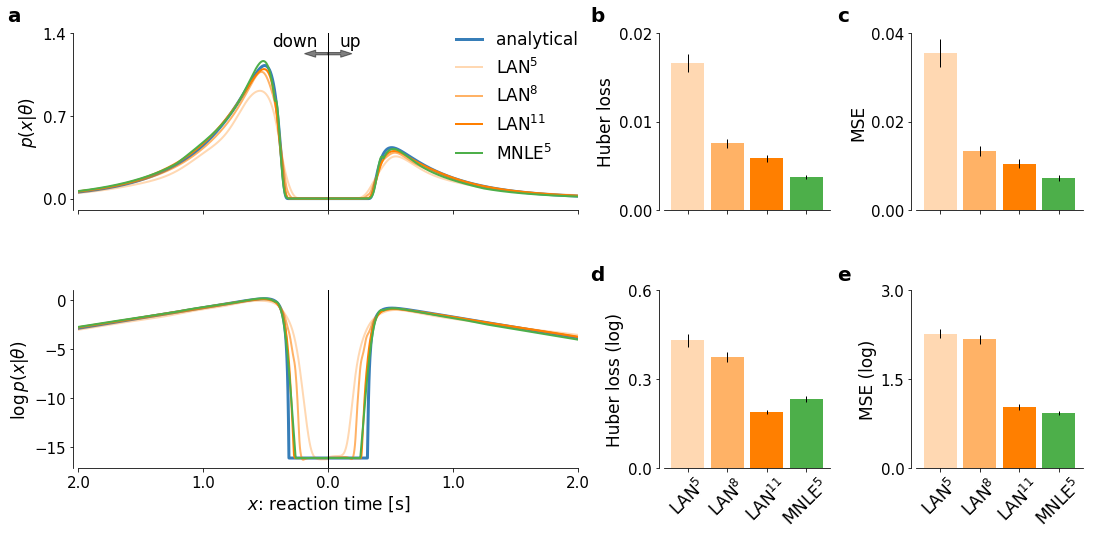

In [17]:
plt.style.use('plotting_settings.mplstyle')
fig, ax = plt.subplots(2, 3, sharex="col", figsize=(18, 8),  
                       gridspec_kw=dict(wspace=0.31, hspace=0.45, width_ratios=[0.6, .2, .2]))

grid = False
showfliers = False
xticks = np.arange(-2, 2.1, 1)

alphas = [1, 0.3, 0.6, 1, 1]
plot_colors = [colors[0], colors[1], colors[1], colors[1], colors[2]]
rotation = 45
y_axis_setoff = -0.01
mpl.rcParams["lines.linewidth"] = 1.
lw = 2


plt.sca(ax[0, 0])
plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0], lw=lw+1);
plt.plot(test_rts, lps_lan_5.exp(), label=labels[1], ls="-", c=colors[1], alpha=alphas[1], lw=lw)
plt.plot(test_rts, lps_lan_8.exp(), label=labels[2], ls="-", c=colors[1], alpha=alphas[2], lw=lw)
plt.plot(test_rts, lps_lan_11.exp(), label=labels[3], ls="-", c=colors[1], alpha=alphas[3], lw=lw)
plt.plot(test_rts, lps_mnle.exp(), label="MNLE", ls="-", c=colors[2], lw=lw);
plt.ylabel(r"$p(x | \theta)$");
plt.legend(labels, loc=1, handlelength=1.5, bbox_to_anchor=(1.03, 1.1))
plt.xticks(xticks, [])
plt.yticks(np.linspace(0, 1.4, 3))
plt.ylim([-.1, 1.4])
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)
y = max(lps_true.exp())+.1
plt.arrow(0, y, 0.1, 0., width=0.02, color="k", alpha=0.5)
plt.text(0.09, 1.05 * y, s="up")
plt.arrow(0, y, -0.1, 0., width=0.02, color="k", alpha=0.5)
plt.text(-.45, 1.05*y, s="down")
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))
# plt.yticks(np.linspace(0, 4, 5), np.linspace(0, 4, 5))
# plt.suptitle(fr"v={theta_o[0, 0]:.2f}, a={theta_o[0, 1]:.2f}, w={theta_o[0, 2]:.2f}, $\tau$={theta_o[0, 3]:.2f}");

plt.sca(ax[1, 0])
plt.plot(test_rts, lps_true, c=colors[0], lw=lw+1)
# plt.plot(test_rts, lps_lanana)
plt.plot(test_rts, lps_lan_5, ls="-", c=colors[1], alpha=alphas[1], lw=lw)
plt.plot(test_rts, lps_lan_8, ls="-", c=colors[1], alpha=alphas[2], lw=lw)
plt.plot(test_rts, lps_lan_11, ls="-", c=colors[1], alpha=alphas[3], lw=lw)
plt.plot(test_rts, lps_mnle, ls="-", c=colors[2], lw=lw)
# plt.legend(labels)
plt.xlabel("$x$: reaction time [s]")
plt.ylabel(r"$\log p(x | \theta)$");
plt.xticks(xticks, abs(xticks))
plt.xlim(-2, 2)
plt.axvline(0, color="k", lw=1)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

y_axis_setoff = -0.03
plt.sca(ax[0, 1])
box_widths = [0.5] * 4
pos = []
width = 0.1
pos_scale = 0.12
for ii in range(4):
    pos.append(ii*pos_scale)
    plot_bar(pos[ii], width, df_huber.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation);
plt.ylabel("Huber loss");
plt.yticks(np.linspace(0, 0.02, 3));
plt.ylim(0, 0.02)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

plt.sca(ax[0, 2])
for ii in range(4):
    plot_bar(pos[ii], width, df_mse.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation);
plt.ylabel(r"MSE");
plt.yticks(np.linspace(0, .04, 3))
plt.ylim(0, .04);
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))


plt.sca(ax[1, 1])
for ii in range(4):
    plot_bar(pos[ii], width, df_huber_log.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"]);
plt.ylabel("Huber loss (log)");
plt.yticks(np.linspace(0, .6, 3));
plt.ylim(0, .6)
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

plt.sca(ax[1, 2])
for ii in range(4):
    plot_bar(pos[ii], width, df_mse_log.values[:, ii], label=labels[ii+1], color=plot_colors[ii+1], alpha=alphas[ii+1])
plt.xticks(pos, labels[1:], rotation=rotation, fontsize=mpl.rcParams["axes.labelsize"]);
plt.ylabel(r"MSE (log)");
plt.yticks(np.linspace(0, 3, 3))
plt.ylim(0, 3);
plt.gca().spines["left"].set_position(("axes", y_axis_setoff))

weight = "bold"
fontsize = 20
y1 = 0.9
x1 = 0.07
dx = .45
dx2 = 0.64
dy = 0.45
fig.text(x1, y1, "a", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1, "b", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1, "c", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx, y1 - dy, "d", fontsize=fontsize, fontweight=weight)
fig.text(x1 + dx2, y1 - dy, "e", fontsize=fontsize, fontweight=weight);
plt.tight_layout()
fig.savefig("figures/Figure2-MNLE-LAN-likelihood-comparison.png", dpi=300, bbox_inches="tight");
fig.savefig("figures/Figure 2.pdf", dpi=400, bbox_inches="tight");

### Medians and pairwise comparisons

In [18]:
# rename columns for better access.
df_huber.columns = ["LAN5", "LAN8", "LAN", "MNLE"]
df_mse.columns = ["LAN5", "LAN8", "LAN", "MNLE"]
df_huber_log.columns = ["LAN5", "LAN8", "LAN", "MNLE"]
df_mse_log.columns = ["LAN5", "LAN8", "LAN", "MNLE"]

In [19]:
print("linear scale")
df_huber.mean(), df_mse.mean()

linear scale


(LAN5    0.016608
 LAN8    0.007546
 LAN     0.005851
 MNLE    0.003765
 dtype: float64,
 LAN5    0.035513
 LAN8    0.013400
 LAN     0.010533
 MNLE    0.007237
 dtype: float64)

In [20]:
print("log scale")
df_huber_log.mean(), df_mse_log.mean()

log scale


(LAN5    0.430696
 LAN8    0.374137
 LAN     0.188713
 MNLE    0.233783
 dtype: float64,
 LAN5    2.267289
 LAN8    2.173839
 LAN     1.032648
 MNLE    0.924024
 dtype: float64)

In [21]:
# helper fun for comparisons
def num_a_greater_b_and_binom_test(a, b):
    num_a_greater_b = (a>b).sum()
    return num_a_greater_b, binom_test(num_a_greater_b, num_observations, 0.5)

In [22]:
print("Huber loss")
for ll in [df_huber.LAN5, df_huber.LAN8, df_huber.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=df_huber.MNLE)
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

print("MLE")
for ll in [df_mse.LAN5, df_mse.LAN8, df_mse.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=df_mse.MNLE)
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

print("Huber loss (log)")
for ll in [df_huber_log.LAN5, df_huber_log.LAN8, df_huber_log.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=df_huber_log.MNLE)
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

print("MSE (log)")
for ll in [df_mse_log.LAN5, df_mse_log.LAN8, df_mse_log.LAN]:
    num_greater, binom_pvalue = num_a_greater_b_and_binom_test(a=ll, b=df_mse_log.MNLE)
    print(f"LAN > MNLE: {num_greater}, p={binom_pvalue}")

Huber loss
LAN > MNLE: 99, p=1.5934990285464438e-28
LAN > MNLE: 81, p=2.7027625220487884e-10
LAN > MNLE: 66, p=0.0017899303914868528
MLE
LAN > MNLE: 98, p=7.969072864542661e-27
LAN > MNLE: 81, p=2.7027625220487884e-10
LAN > MNLE: 66, p=0.0017899303914868528
Huber loss (log)
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 38, p=0.02097873567785172
MSE (log)
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 100, p=1.5777218104420236e-30
LAN > MNLE: 75, p=5.636282034205402e-07
